In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import shutil
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from IPython.display import Image, display

In [3]:
gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')

In [17]:
base_dir = '../GLD3_complete/GrIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'

good_dir = 'good_lake/'
bad_depth_dir = 'lake_bad_depth/'
nolake_dir = 'bad_no_lake/'

In [19]:
searchfor = '_context.jpg'

# good lakes
searchdir = base_dir + context_dir + good_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i good lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_good = pd.DataFrame({'lake_id': fl, 'label': good_dir.replace('/','')})

# lakes with bad depth
searchdir = base_dir + context_dir + bad_depth_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i bad depth lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_bad = pd.DataFrame({'lake_id': fl, 'label': bad_depth_dir.replace('/','')})

# lakes with bad depth
searchdir = base_dir + context_dir + nolake_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i bad depth lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_nolake = pd.DataFrame({'lake_id': fl, 'label': nolake_dir.replace('/','')})
df_nolake

df_labels = pd.concat([df_good, df_bad, df_nolake]).reset_index(drop=True)
df_labels

There are 7395 good lake files.
There are 1391 bad depth lake files.
There are 6312 bad depth lake files.


,lake_id,label
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake
...,...,...
15093,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15094,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15095,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake
15096,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake


In [35]:
exists = df_labels.apply(lambda x: os.path.isfile('%s%s%s.h5' % (base_dir, data_dir, x.lake_id)), axis=1)
np.sum(~exists)

0

In [49]:
def get_attributes(r):
    fn = '%s%s%s.h5' % (base_dir, data_dir, r.lake_id)
    try:
        with h5py.File(fn, 'r') as f:
            return pd.Series({
                'lon': f['properties']['lon'][()],
                'lat': f['properties']['lat'][()],
                'surface_elevation': f['properties']['surface_elevation'][()],
                'date_time': f['properties']['date_time'][()].decode('utf-8'),
                'depth_quality_sort': f['properties']['depth_quality_sort'][()],
                'max_depth': f['properties']['max_depth'][()],
                'beam_strength': f['properties']['beam_strength'][()].decode('utf-8')
            })
    except:
        return pd.Series({
                'lon': np.nan,
                'lat': np.nan,
                'surface_elevation': np.nan,
                'date_time': '',
                'depth_quality_sort': np.nan,
                'max_depth': np.nan,
                'beam_strength': ''
            })

df_labels = pd.concat((df_labels, df_labels.apply(get_attributes, axis=1)), axis=1)
df_labels

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-49.895976,70.437430,863.975706,2019-08-18T03:49:28Z,3.414623e+14,11.845931,weak
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,-29.452426,72.077225,1576.515319,2019-08-01T03:14:32Z,1.398473e+02,8.264746,weak
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.989571,70.329607,1440.634057,2019-08-14T03:57:44Z,1.388842e+02,4.654427,weak
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.429319,68.981759,1185.275591,2019-08-14T03:57:22Z,1.002200e+02,13.051067,weak
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.431568,68.981906,1185.287005,2019-08-14T03:57:22Z,8.950596e+01,12.472857,strong
...,...,...,...,...,...,...,...,...,...
15093,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-49.704020,63.051652,-1.638607,2023-09-20T04:35:05Z,0.000000e+00,0.099605,weak
15094,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-49.557224,62.686891,710.370493,2023-09-20T04:34:59Z,0.000000e+00,0.190547,strong
15095,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-50.029695,64.648020,-1.372965,2023-09-20T04:35:30Z,0.000000e+00,1.846882,strong
15096,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,bad_no_lake,-50.028005,64.648449,-1.356150,2023-09-20T04:35:30Z,0.000000e+00,0.918039,weak


## Remove corrupted data files that can't be opened


lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027
../GLD3_complete/GrIS/detection_out_data/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027.h5
file exists, deleting
../GLD3_complete/GrIS/detection_context/bad_no_lake/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_context.jpg


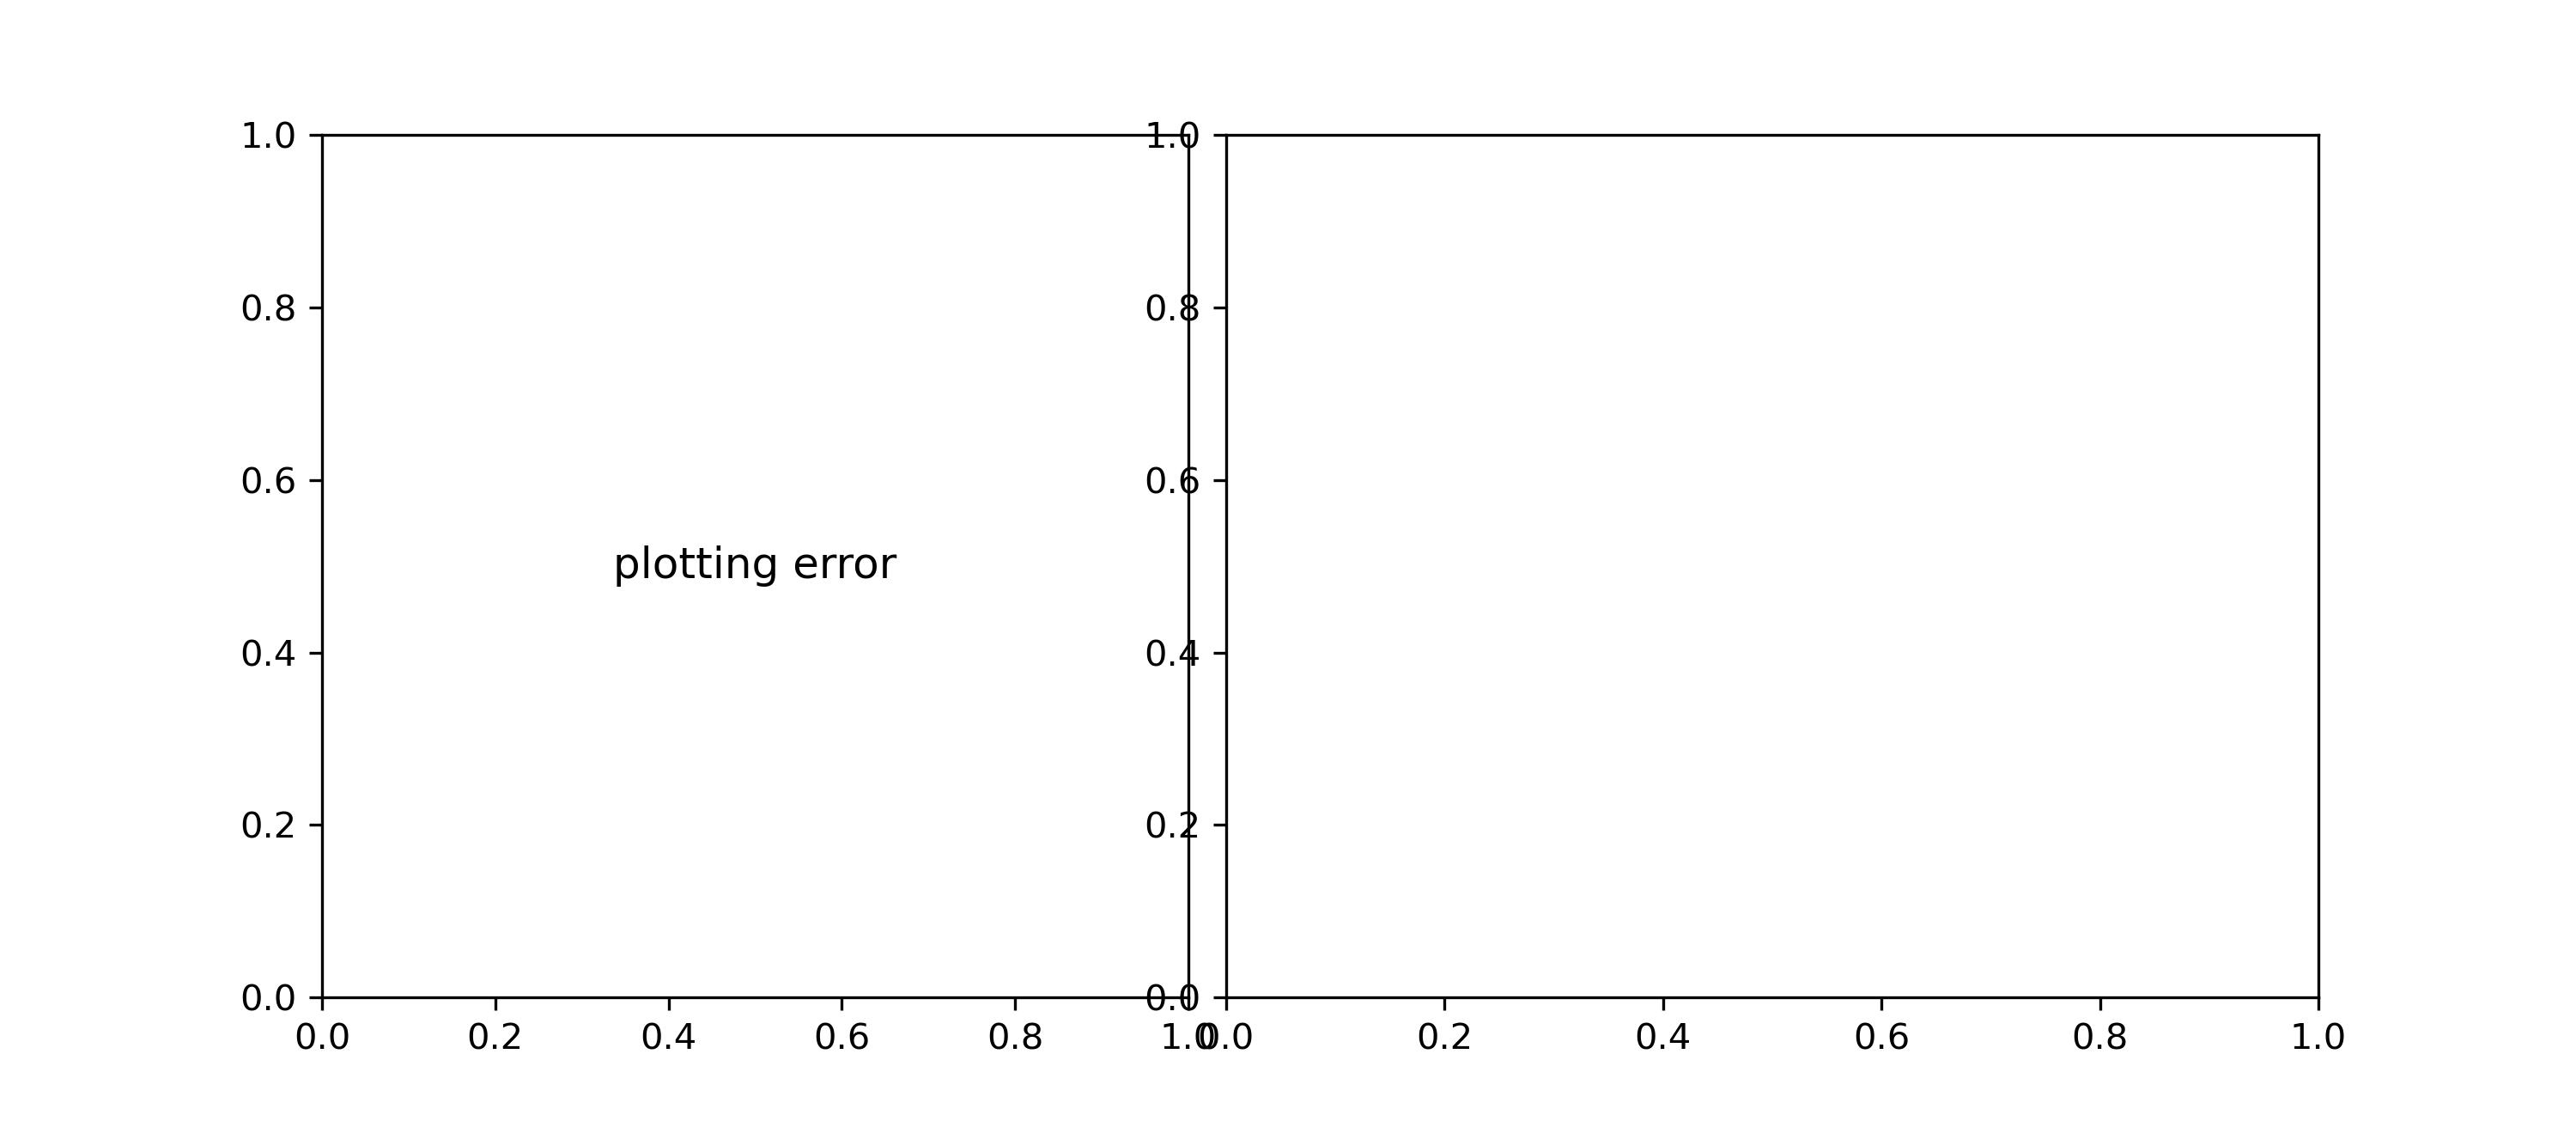

file exists, deleting
../GLD3_complete/GrIS/detection_imagery/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027.tiff
imagery does not exist
../GLD3_complete/GrIS/detection_out_plot/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_quicklook.jpg
quicklook image does not exist
../GLD3_complete/GrIS/detection_out_plot/lake_099981_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3r_0027_details.jpg
quicklook image does not exist


In [75]:
# for idx in df_labels[np.isnan(df_labels.lon)].index:
    
#     x = df_labels.loc[idx].copy()
#     print('\n%s' % x.lake_id)
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     print(fc)
#     if os.path.isfile(fc):
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + context_dir + x.label + '/' + x.lake_id + '_context.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + imagery_dir + x.lake_id + '.tiff'
#     print(fc)
#     if os.path.isfile(fc):
#         print('imagery exists')
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('imagery does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')

# df_labels = df_labels[~np.isnan(df_labels.lon)].reset_index(drop=True)

In [77]:
# df_labels.to_csv(base_dir + 'lake_labels.csv', index=False)

## quick plot of label vs. depth_quality_sort

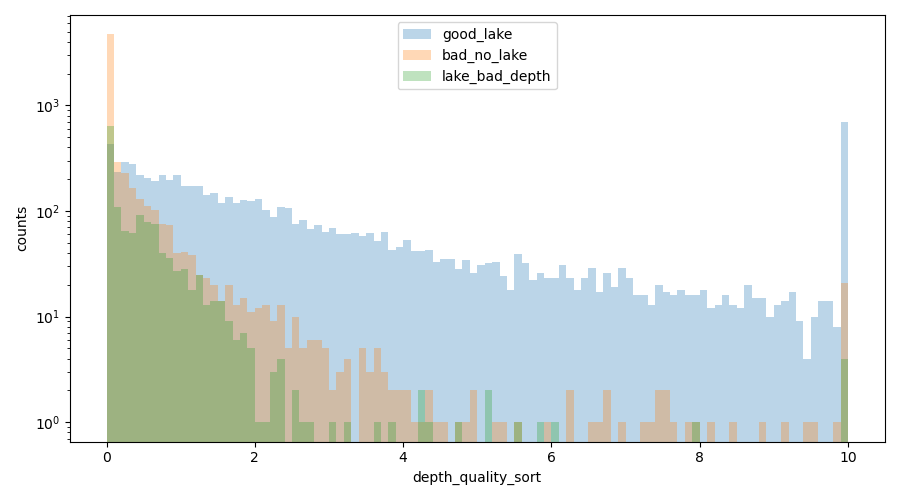

In [89]:
df_labels = pd.read_csv(base_dir + 'lake_labels.csv')
fig, ax = plt.subplots(figsize=(9,5))

maxval = 10
al = 0.3
bins = np.linspace(0, maxval, 101)
dft = df_labels[df_labels.label == 'good_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C0', alpha=al, label='good_lake')
dft = df_labels[df_labels.label == 'bad_no_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C1', alpha=al, label='bad_no_lake')
dft = df_labels[df_labels.label == 'lake_bad_depth']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C2', alpha=al, label='lake_bad_depth')

ax.set_yscale('log')

ax.set_xlabel('depth_quality_sort')
ax.set_ylabel('counts')

ax.legend(loc='upper center')

fig.tight_layout()

## move the files

In [100]:
# for idx in df_labels.index:

#     x = df_labels.loc[idx].copy()
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     moveto = base_dir + data_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - data does not exist: %s' % (idx,fc))
    
#     fc = base_dir + imagery_dir + x.lake_id + '_imagery.tif'
#     moveto = base_dir + imagery_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - imagery does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - quicklook image does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - details image does not exist: %s' % (idx,fc))

112 - imagery does not exist: ../GLD3_complete/GrIS/detection_imagery/lake_097561_GrIS_2023_simplified_GRE_2200_NE_ATL03_20230813175112_08332005_006_02_gt1l_0000_imagery.tif
2050 - imagery does not exist: ../GLD3_complete/GrIS/detection_imagery/lake_099610_GrIS_2021_simplified_GRE_2200_SW_ATL03_20210729062325_05441205_006_01_gt1l_0023_imagery.tif
2647 - quicklook image does not exist: ../GLD3_complete/GrIS/detection_out_plot/lake_099711_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3l_0021_quicklook.jpg
2647 - quicklook image does not exist: ../GLD3_complete/GrIS/detection_out_plot/lake_099711_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt3l_0021_details.jpg
2716 - quicklook image does not exist: ../GLD3_complete/GrIS/detection_out_plot/lake_099720_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt1l_0000_quicklook.jpg
2716 - quicklook image does not exist: ../GLD3_complete/GrIS/detection_out_plot/lake_099720_GrI

In [45]:
dftemp = df_labels.iloc[:10].copy()
dftemp.apply(get_attributes, axis=1)
pd.concat((dftemp, dftemp.apply(get_attributes, axis=1)), axis=1)

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-49.895976,70.437430,863.975706,2019-08-18T03:49:28Z,3.414623e+14,11.845931,weak
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,-29.452426,72.077225,1576.515319,2019-08-01T03:14:32Z,1.398473e+02,8.264746,weak
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.989571,70.329607,1440.634057,2019-08-14T03:57:44Z,1.388842e+02,4.654427,weak
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.429319,68.981759,1185.275591,2019-08-14T03:57:22Z,1.002200e+02,13.051067,weak
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.431568,68.981906,1185.287005,2019-08-14T03:57:22Z,8.950596e+01,12.472857,strong
5,lake_091299_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-47.768970,69.325233,1465.025873,2019-08-10T04:05:47Z,8.700536e+01,9.919545,strong
6,lake_091427_GrIS_2021_simplified_GRE_2200_NW_A...,good_lake,-60.162134,76.214080,596.945407,2021-08-20T06:25:47Z,8.572696e+01,8.499113,weak
7,lake_092438_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-47.766681,69.325053,1465.015560,2019-08-10T04:05:47Z,7.562189e+01,8.270290,weak
8,lake_092894_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-48.747326,69.429331,1167.575913,2019-08-14T03:57:30Z,7.106130e+01,19.126893,weak
9,lake_092937_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,-49.022563,69.738999,1261.118625,2019-07-16T05:21:21Z,7.063419e+01,10.624326,weak


In [ ]:
def get_attributes(r):
    fn = '%s%s%s.h5' % (base_dir, data_dir, r.lake_id)
    with h5py.File(fn, 'r') as f:
        return pd.Series({
            'lon': f['properties']['lon'][()],
            'lat': f['properties']['lat'][()],
            'surface_elevation': f['properties']['surface_elevation'][()],
            'date_time': f['properties']['date_time'][()].decode('utf-8'),
            'depth_quality_sort': f['properties']['depth_quality_sort'][()],
            'max_depth': f['properties']['max_depth'][()],
            'beam_strength': f['properties']['beam_strength'][()].decode('utf-8')
        })

df_labels.apply(get_attributes, axis=1)

In [28]:
r = df_labels.iloc[1]
def get_attributes(r):
    fn = '%s%s%s.h5' % (base_dir, data_dir, r.lake_id)
    with h5py.File(fn, 'r') as f:
        return pd.DataFrame({
            'lon': f['properties']['lon'][()],
            'lat': f['properties']['lat'][()],
            'surface_elevation': f['properties']['surface_elevation'][()],
            'date_time': f['properties']['date_time'][()].decode('utf-8'),
            'depth_quality_sort': f['properties']['depth_quality_sort'][()],
            'max_depth': f['properties']['max_depth'][()],
            'beam_strength': f['properties']['beam_strength'][()].decode('utf-8')
        }, index=[0])
get_attributes(r) 

<KeysViewHDF5 ['beam_number', 'beam_strength', 'cycle_number', 'date_time', 'dead_time', 'dead_time_meters', 'depth_quality_sort', 'detection_quality', 'full_lat_extent_detection', 'granule_id', 'gtx', 'ice_sheet', 'lake_id', 'lake_quality', 'lat', 'lat_max', 'lat_min', 'lat_str', 'lat_surface_extent_detection', 'len_subsegs', 'length_extent', 'length_water_surfaces', 'lon', 'lon_max', 'lon_min', 'lon_str', 'main_peak', 'max_depth', 'melt_season', 'mframe_end', 'mframe_start', 'n_photons_where_water', 'n_subsegs_per_mframe', 'oaurl', 'polygon_filename', 'polygon_name', 'quality_sort', 'rgt', 'sc_orient', 'surface_elevation', 'surface_extent_detection']>


,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,-29.452426,72.077225,1576.515319,2019-08-01T03:14:32Z,139.847287,8.264746,weak
